# Setup

In [16]:
import re
import pandas as pd
import numpy as np
import spacy
from spacy import displacy 
import syllables
import matplotlib.pyplot as plt

from nltk import bigrams, trigrams
from collections import Counter, defaultdict

In [2]:
pd.set_option('display.max_rows', 100)

# Load data

In [3]:
df = pd.read_csv("../data/okcupid_profiles.csv")
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


## Add more meaningful column names instead of essay[0-9]

In [4]:
df.rename(
    columns={"essay0": "about_me",
     "essay1": "aspirations",
     "essay2": "talent",
     "essay3": "my_traits",
     "essay4": "hobbies1",
     "essay5": "needs",
     "essay6": "hobbies2",
     "essay7": "moments",
     "essay8": "secrets",
     "essay9": "dating"
    },
    inplace=True)
df.head(1)

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,about_me,aspirations,talent,my_traits,hobbies1,needs,hobbies2,moments,secrets,dating
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...


# Transform

## Replace NaN to empty string in free text fields

In [5]:
df.iloc[:,21:-1] = df.iloc[:,21:-1].fillna("") 
df.iloc[0:5,21:-1]

,about_me,aspirations,talent,my_traits,hobbies1,needs,hobbies2,moments,secrets
0,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...
1,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,,,i am very open and will share just about anyth...
2,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the..."
3,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",,cats and german philosophy,,
4,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",,,,


## Aggregate text fields

In [6]:
df["text"] = df.iloc[:,21:-1].agg("\n\n".join, axis=1)
df["text"].head(10)

0    about me:  i would love to think that i was so...
1    i am a chef: this is what that means. 1. i am ...
2    i'm not ashamed of much, but writing public te...
3    i work in a library and go to school. . .\n\nr...
4    hey how's it going? currently vague on the pro...
5    i'm an australian living in san francisco, but...
6    life is about the little things. i love to lau...
7    \n\nwriting. meeting new people, spending time...
8    \n\noh goodness. at the moment i have 4 jobs, ...
9    my names jake. i'm a creative guy and i look f...
Name: text, dtype: object

## Tokenization

In [7]:
def tokenize(text):
    tokens = re.findall(r"[\w.!?]+", text.lower())
    sentences = []
    sentence = []
    for t in tokens:
        if t[-1] in ".!?":
            sentence.append(t[:-1])
            if not re.match("(\d|e\.g|etc|pls)\.", t):
                sentences.append(sentence)
                sentence = []
        else:
            sentence.append(t)
    return sentences
    
tokenize(df["text"][1])[0:3]

[['i', 'am', 'a', 'chef', 'this', 'is', 'what', 'that', 'means'],
 ['1', 'i', 'am', 'a', 'workaholic'],
 ['2',
  'i',
  'love',
  'to',
  'cook',
  'regardless',
  'of',
  'whether',
  'i',
  'am',
  'at',
  'work']]

In [8]:
df["tokens"] = df["text"].apply(tokenize)
df["tokens"].head(3)

0    [[about, me, i, would, love, to, think, that, ...
1    [[i, am, a, chef, this, is, what, that, means]...
2    [[i, m, not, ashamed, of, much, but, writing, ...
Name: tokens, dtype: object

# Simple metrics

In [9]:
def calc_token_count(doc):
    count = 0
    for sentence in doc:
        for token in sentence:
            count = count + 1
    return count

df["tokens"][0:3].apply(calc_token_count)

0    426
1    270
2    853
Name: tokens, dtype: int64

In [10]:
df["token_count"] = df["tokens"].apply(calc_token_count)

## Flesch–Kincaid readability score

As described [here](https://en.wikipedia.org/wiki/Readability#Popular_readability_formulas)

In [30]:
def calc_readability(doc):
    if len(doc) == 0:
        return None
    sentence_length_arr = np.empty(len(doc))
    word_syllable_count = []
    for i, sentence in enumerate(doc):
        sentence_length_arr[i] = len(sentence)
        for token in sentence:
            word_syllable_count.append(syllables.estimate(token))
    avg_sentence_length = np.average(sentence_length_arr)
    avg_word_syllable_count = np.average(np.array(word_syllable_count))
    return 206.835 - (1.015 * avg_sentence_length) - (84.6 * avg_word_syllable_count)

In [31]:
df["readability"] = df["tokens"].apply(calc_readability)

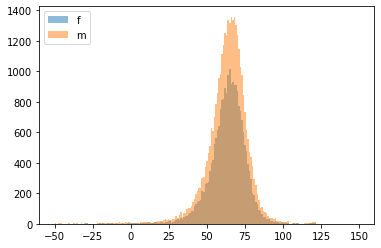

In [33]:
bins = np.linspace(-50, 150, 200)
plt.hist(df[df["sex"] == "f"]["readability"], bins, alpha=0.5, label="f")
plt.hist(df[df["sex"] == "m"]["readability"], bins, alpha=0.5, label="m")
plt.legend(loc="upper left")

Most complex sentence

In [44]:
df.sort_values(by = "readability")["text"][0]

"about me:  i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes.  about you:  you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, and tele

## Gender document separation

In [34]:
female_docs = df[(df["sex"] == "f") & (df["token_count"] > 0)]["tokens"]
male_docs   = df[(df["sex"] == "m") & (df["token_count"] > 0)]["tokens"]

In [35]:
female_sentences = [s for doc in female_docs for s in doc]
male_sentences = [s for doc in male_docs for s in doc]

# Ngram models

In [36]:
def create_model(sentences):
    model = defaultdict(lambda: defaultdict(lambda: 0))
    for i, sentence in enumerate(sentences):
        for w1, w2, w3 in trigrams(sentence, pad_right=True, pad_left=True):
            model[(w1, w2)][w3] += 1
    return model

In [37]:
female_model = create_model(female_sentences)
male_model = create_model(male_sentences)

In [38]:
def ngram_to_dataframe(model):
    record_list_trigram = []
    for i, key_1 in enumerate(model):
        bigram = key_1
        next_words = model[bigram]
        for key_2 in next_words:
            third_word = key_2
            count = next_words[third_word]

            records_trigram = {}
            records_trigram["first_word"] = bigram[0]
            records_trigram["second_word"] = bigram[1]
            records_trigram["third_word"] = third_word
            records_trigram["count"] = count
            record_list_trigram.append(records_trigram)
    return pd.DataFrame(record_list_trigram) 

In [39]:
df_female_trigrams = ngram_to_dataframe(female_model)
df_female_trigrams

,first_word,second_word,third_word,count
0,None,None,life,1048
1,None,None,i,194211
2,None,None,it,8106
3,None,None,this,2859
4,None,None,we,1457
...,...,...,...,...
3940185,the,alconquin,in,1
3940186,alconquin,in,nyc,1
3940187,italy,along,the,1
3940188,terre,working,in,1


In [40]:
df_male_trigrams = ngram_to_dataframe(male_model)
df_male_trigrams

,first_word,second_word,third_word,count
0,None,None,about,386
1,None,None,can,853
2,None,None,i,252041
3,None,None,like,1551
4,None,None,my,26179
...,...,...,...,...
5551052,friends,ranting,about,1
5551053,something,hardly,worth,1
5551054,rant,.,None,1
5551055,could,cry,like,1


In [57]:
df_female_trigrams[
    (df_female_trigrams["first_word"] == "a") & 
    (df_female_trigrams["second_word"] == "better")] \
        .sort_values(by="count", ascending = False) \
        .head(15)

,first_word,second_word,third_word,count
235034,a,better,place,348
235035,a,better,person,271
235039,a,better,friend,25
235065,a,better,me,20
235036,a,better,teacher,19
235058,a,better,world,18
235057,a,better,life,17
235037,a,better,human,16
235051,a,better,way,16
235046,a,better,job,16


In [58]:
df_male_trigrams[
    (df_male_trigrams["first_word"] == "a") & 
    (df_male_trigrams["second_word"] == "better")] \
        .sort_values(by="count", ascending = False) \
        .head(15)

,first_word,second_word,third_word,count
581990,a,better,place,485
581991,a,better,person,315
582003,a,better,world,48
581993,a,better,way,47
581995,a,better,job,39
581998,a,better,man,38
582004,a,better,life,36
582005,a,better,future,24
582084,a,better,cook,22
582002,a,better,idea,21


# Spacy

In [ ]:
nlp_model = spacy.load("en_core_web_lg")

In [53]:
df.sort_values(by = "readability", ascending=True)["readability"][0]

69.74786508524836

In [54]:
df.head()["readability"]

0    69.747865
1    72.366667
2    44.691877
3    61.449069
4    65.130180
Name: readability, dtype: float64